In [13]:
import pandas as pd
import datetime as dt
import numpy as np
%matplotlib inline

In [8]:
date_parser = lambda x: dt.datetime.strptime(x[0:16], '%d.%m.%Y %H:%M')

In [77]:
data_raw1 = pd.read_csv('./raw_data/Total Load - Day Ahead Forecast - Actual_201501010000-201601010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw2 = pd.read_csv('./raw_data/Total Load - Day Ahead Forecast- Actual_201601010000-201701010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw3 = pd.read_csv('./raw_data/Total Load - Day Ahead Forecast - Actual_201701010000-201801010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw = pd.concat([data_raw1, data_raw2, data_raw3])

data_raw1_f = pd.read_csv('./raw_data/Generation Forecasts - Day Ahead for Wind and Solar_201501010000-201601010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw2_f = pd.read_csv('./raw_data/Generation Forecasts - Day Ahead for Wind and Solar_201601010000-201701010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw3_f = pd.read_csv('./raw_data/Generation Forecasts - Day Ahead for Wind and Solar_201701010000-201801010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw= pd.concat([data_raw1, data_raw2, data_raw3, data_raw1_f, data_raw2_f, data_raw3_f])

In [78]:
data_raw = data_raw.replace(['-', 'n/e'], np.NaN).dropna(how='all')

In [79]:
data_raw.columns

Index(['Actual Total Load [MW] - BZN|DE-AT-LU',
       'Day-ahead Total Load Forecast [MW] - BZN|DE-AT-LU',
       'Generation - Solar  [MW] (D) / BZN|DE-AT-LU',
       'Generation - Sum [MW] (D) / BZN|DE-AT-LU',
       'Generation - Wind Offshore  [MW] (D) / BZN|DE-AT-LU',
       'Generation - Wind Onshore  [MW] (D) / BZN|DE-AT-LU'],
      dtype='object')

In [80]:
# ['Day-ahead Total Load Forecast [MW] - BZN|DE-AT-LU']
data = pd.DataFrame(data_raw.astype(float))

data.columns = ['DA_load_forecast', 'DA_load_actual', 'solar', 'sum', 'offshore', 'onshore']

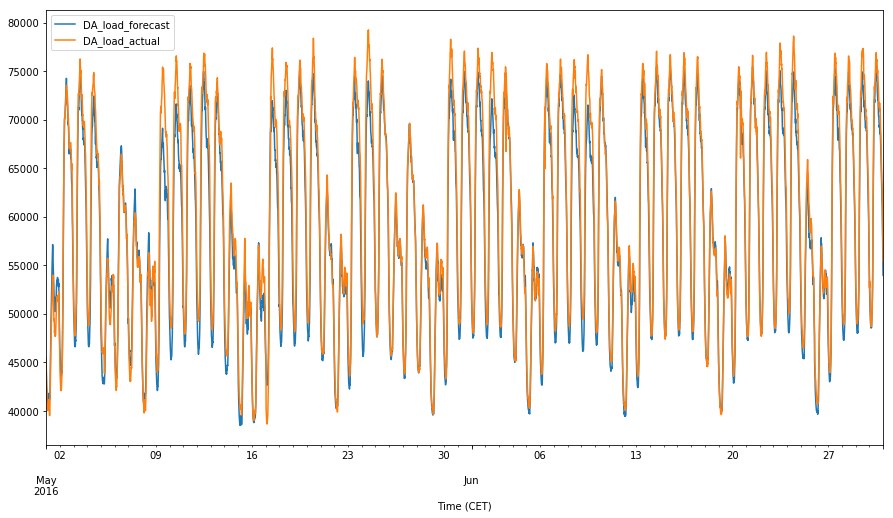

In [32]:
data['2016-05':'2016-06'].plot(figsize=(15, 8))

In [81]:
da_raw = pd.read_csv('./raw_data/EPEX_spot_DA_auction_hour_prices_20070720-20170831.csv',
                     index_col=0, parse_dates=True)
da_raw.head(n=5)

,DA_price
2007-07-20 00:00:00,25.69
2007-07-20 01:00:00,26.45
2007-07-20 02:00:00,24.33
2007-07-20 03:00:00,23.57
2007-07-20 04:00:00,18.96


In [82]:
# keep raw data of the test set for model evaluation
test_raw = da_raw['2017']

In [35]:
da_prep = pd.DataFrame(index=da_raw.index)

# calculate quantiles and inter-quantile range of the data
q75 = da_raw['DA_price'].quantile(.75)
q25 = da_raw['DA_price'].quantile(.25)
IQR = q75 - q25

# values larger (smaller) than q75 (q25) plus 'tol' times IQR get replaces by that value
tol = 3
da_prep['DA_price'] = da_raw['DA_price'].apply(lambda x: q75 + tol * IQR if (x > q75 + tol * IQR) else x)
da_prep['DA_price'] = da_prep['DA_price'].apply(lambda x: q25 - tol * IQR if (x < q75 - tol * IQR) else x)

In [83]:
plotdata = data.join(da_raw).fillna(method='ffill', axis=0)

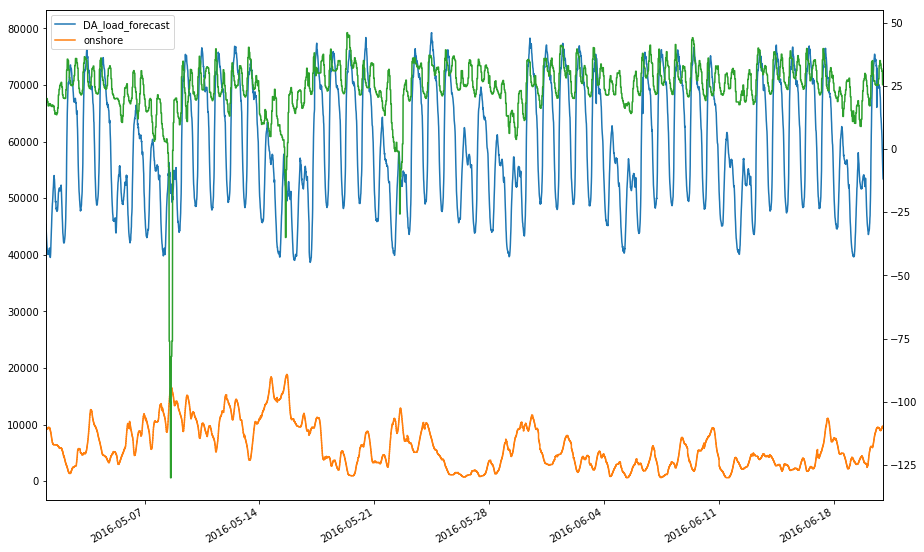

In [97]:
plotdata.loc['2016-05-01':'2016-06-20',['DA_load_forecast', 'onshore']].plot(figsize=(15,10))
plotdata.loc['2016-05-01':'2016-06-20', 'DA_price'].plot(figsize=(15,10), secondary_y=True)